# Approaches to predict the Purchase are:
* Multiple Linear Regression: RMSE of Validation Set = 6416.093
* Backward Subsetting of variables: RMSE of Validation Set = 3230.107
* Lasso Regression: RMSE of Validation Set = 2970.445

* Leaderboard Accuracy (for test set): 2992.02138074499

In [1]:
library(dplyr)
library(caTools)
library(mltools)
library(MASS)
library(leaps)
library(glmnet)
library(ISLR)
library(car)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: Matrix

Loaded glmnet 3.0-1


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode




In [2]:
train = read.csv('../input/black-friday/train.csv')
test = read.csv('../input/black-friday/test.csv')

# Preprocessing

In [3]:
Purchase = 0
test = cbind(test, Purchase)

data = rbind(train, test)

str(data)

'data.frame':	783667 obs. of  12 variables:
 $ User_ID                   : int  1000001 1000001 1000001 1000001 1000002 1000003 1000004 1000004 1000004 1000005 ...
 $ Product_ID                : Factor w/ 3677 levels "P00000142","P00000242",..: 673 2377 853 829 2735 1832 1746 3321 3605 2632 ...
 $ Gender                    : Factor w/ 2 levels "F","M": 1 1 1 1 2 2 2 2 2 2 ...
 $ Age                       : Factor w/ 7 levels "0-17","18-25",..: 1 1 1 1 7 3 5 5 5 3 ...
 $ Occupation                : int  10 10 10 10 16 15 7 7 7 20 ...
 $ City_Category             : Factor w/ 3 levels "A","B","C": 1 1 1 1 3 1 2 2 2 1 ...
 $ Stay_In_Current_City_Years: Factor w/ 5 levels "0","1","2","3",..: 3 3 3 3 5 4 3 3 3 2 ...
 $ Marital_Status            : int  0 0 0 0 0 0 1 1 1 1 ...
 $ Product_Category_1        : int  3 1 12 12 8 1 1 1 1 8 ...
 $ Product_Category_2        : int  NA 6 NA 14 NA 2 8 15 16 NA ...
 $ Product_Category_3        : int  NA 14 NA NA NA NA 17 NA NA NA ...
 $ Purchase          

In [4]:
colSums(is.na(data))

User_ID                 Product_ID 
                         0                          0 
                    Gender                        Age 
                         0                          0 
                Occupation              City_Category 
                         0                          0 
Stay_In_Current_City_Years             Marital_Status 
                         0                          0 
        Product_Category_1         Product_Category_2 
                         0                     245982 
        Product_Category_3                   Purchase 
                    545809                          0

In [5]:
summary(data$Gender)
summary(data$Age)

F      M 
193636 590031

0-17  18-25  26-35  36-45  46-50  51-55    55+ 
 21334 141953 313015 156724  65278  54784  30579

In [6]:
summary(data$Stay_In_Current_City_Years)

levels(data$Stay_In_Current_City_Years)
data$Stay_In_Current_City_Years = ordered(as.numeric(data$Stay_In_Current_City_Years) - 1)

0      1      2      3     4+ 
105716 276425 145427 135428 120671

[1] "0"  "1"  "2"  "3"  "4+"

In [7]:
data$Marital_Status = as.factor(data$Marital_Status)
summary(data$Marital_Status)

0      1 
462538 321129

In [8]:
data$Occupation = as.factor(data$Occupation)
summary(data$Occupation)

0      1      2      3      4      5      6      7      8      9     10 
 98850  67687  37996  25126 103086  17373  29102  84127   2189   8929  18304 
    11     12     13     14     15     16     17     18     19     20 
 16593  44448  11053  38782  17356  36122  57418   9367  11919  47840

In [9]:
summary(as.factor(data$Product_Category_2))
data = data %>% mutate(Product_Category_2=replace(Product_Category_2, is.na(Product_Category_2), -1))
data$Product_Category_2 = as.factor(data$Product_Category_2)
summary(data$Product_Category_2)

2      3      4      5      6      7      8      9     10     11     12 
 70498   4123  36705  37165  23575    854  91317   8177   4420  20230   7801 
    13     14     15     16     17     18   NA's 
 15054  78834  54114  61687  19104   4027 245982

-1      2      3      4      5      6      7      8      9     10     11 
245982  70498   4123  36705  37165  23575    854  91317   8177   4420  20230 
    12     13     14     15     16     17     18 
  7801  15054  78834  54114  61687  19104   4027

In [10]:
summary(as.factor(data$Product_Category_3))
data = data %>% mutate(Product_Category_3=replace(Product_Category_3, is.na(Product_Category_3), -1))
data$Product_Category_3 = as.factor(data$Product_Category_3)
summary(data$Product_Category_3)

3      4      5      6      8      9     10     11     12     13     14 
   878   2691  23799   6888  17861  16532   2501   2585  13115   7849  26283 
    15     16     17     18   NA's 
 39968  46469  23818   6621 545809

-1      3      4      5      6      8      9     10     11     12     13 
545809    878   2691  23799   6888  17861  16532   2501   2585  13115   7849 
    14     15     16     17     18 
 26283  39968  46469  23818   6621

In [11]:
data$Product_Category_1 = as.factor(data$Product_Category_1)
summary(data$Product_Category_1)

1      2      3      4      5      6      7      8      9     10     11 
200699  34056  28791  16756 215950  29326   5345 162294    604   7373  34440 
    12     13     14     15     16     17     18     19     20 
  5610   7930   2186   8984  13933    801   4436   1603   2550

In [12]:
data = data[-c(1, 2)]
str(data)

'data.frame':	783667 obs. of  10 variables:
 $ Gender                    : Factor w/ 2 levels "F","M": 1 1 1 1 2 2 2 2 2 2 ...
 $ Age                       : Factor w/ 7 levels "0-17","18-25",..: 1 1 1 1 7 3 5 5 5 3 ...
 $ Occupation                : Factor w/ 21 levels "0","1","2","3",..: 11 11 11 11 17 16 8 8 8 21 ...
 $ City_Category             : Factor w/ 3 levels "A","B","C": 1 1 1 1 3 1 2 2 2 1 ...
 $ Stay_In_Current_City_Years: Ord.factor w/ 5 levels "0"<"1"<"2"<"3"<..: 3 3 3 3 5 4 3 3 3 2 ...
 $ Marital_Status            : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 2 2 2 2 ...
 $ Product_Category_1        : Factor w/ 20 levels "1","2","3","4",..: 3 1 12 12 8 1 1 1 1 8 ...
 $ Product_Category_2        : Factor w/ 18 levels "-1","2","3","4",..: 1 6 1 14 1 2 8 15 16 1 ...
 $ Product_Category_3        : Factor w/ 16 levels "-1","3","4","5",..: 1 12 1 1 1 1 15 1 1 1 ...
 $ Purchase                  : num  8370 15200 1422 1057 7969 ...


# Segregating train test data

In [13]:
train_ = data[1:nrow(train),]
test_ = data[(nrow(train) + 1):nrow(data),]

# Splitting train data into train-validation set

In [14]:
set.seed(123)
split = sample.split(train_$Purchase, SplitRatio = 0.8)
training_set = subset(train_, split==TRUE)
validation_set = subset(train_, split==FALSE)

In [15]:
X_train = model.matrix(Purchase ~ ., data = training_set)[,-1]
X_val = model.matrix(Purchase ~ ., data = validation_set)[,-1]

# Normal Multiple Linear Regression

In [16]:
lm.fit = lm(Purchase ~ ., data = training_set)
summary(lm.fit)
pred_lm = predict(lm.fit, newx = X_val)
sqrt(mean((validation_set$Purchase - pred_lm)^2))


Call:
lm(formula = Purchase ~ ., data = training_set)

Residuals:
     Min       1Q   Median       3Q      Max 
-15370.2  -1535.7    358.8   1964.8  10135.3 

Coefficients:
                               Estimate Std. Error  t value Pr(>|t|)    
(Intercept)                   1.326e+04  4.909e+01  270.008  < 2e-16 ***
GenderM                      -5.792e+01  1.096e+01   -5.283 1.27e-07 ***
Age18-25                     -1.836e+02  4.508e+01   -4.074 4.62e-05 ***
Age26-35                     -1.100e+02  4.494e+01   -2.447 0.014397 *  
Age36-45                      1.703e-01  4.559e+01    0.004 0.997019    
Age46-50                      1.747e+01  4.763e+01    0.367 0.713730    
Age51-55                      2.537e+02  4.820e+01    5.263 1.42e-07 ***
Age55+                        1.241e+02  5.100e+01    2.433 0.014994 *  
Occupation1                  -3.071e+01  2.005e+01   -1.531 0.125732    
Occupation2                   3.830e+01  2.410e+01    1.589 0.112075    
Occupation3            

Warning message in validation_set$Purchase - pred_lm:
“longer object length is not a multiple of shorter object length”


[1] 6416.093

# Subsetting Approach

In [17]:
nvmax_ = 9

subset.fit = regsubsets(Purchase ~ ., data = training_set, method='backward', nvmax = nvmax_)
k = summary(subset.fit)
k$adjr2

[1] 0.1369772 0.2344300 0.3252936 0.4115121 0.4699232 0.5086275 0.5388617
[8] 0.5632286 0.5840104

In [18]:
val.errors = rep(NA, nvmax_)
for(i in 1:nvmax_){
  coefi = coef(subset.fit, id=i)
  pred = cbind(1, X_val[,names(coefi[-c(1)])]) %*% coefi
  val.errors[i]= sqrt(mean((validation_set$Purchase - pred) ^2))
}
val.errors
val.errors[which.min(val.errors)]

[1] 4652.753 4386.117 4121.366 3844.204 3648.251 3509.448 3398.823 3310.396
[9] 3230.107

[1] 3230.107

# Lasso Regression

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”


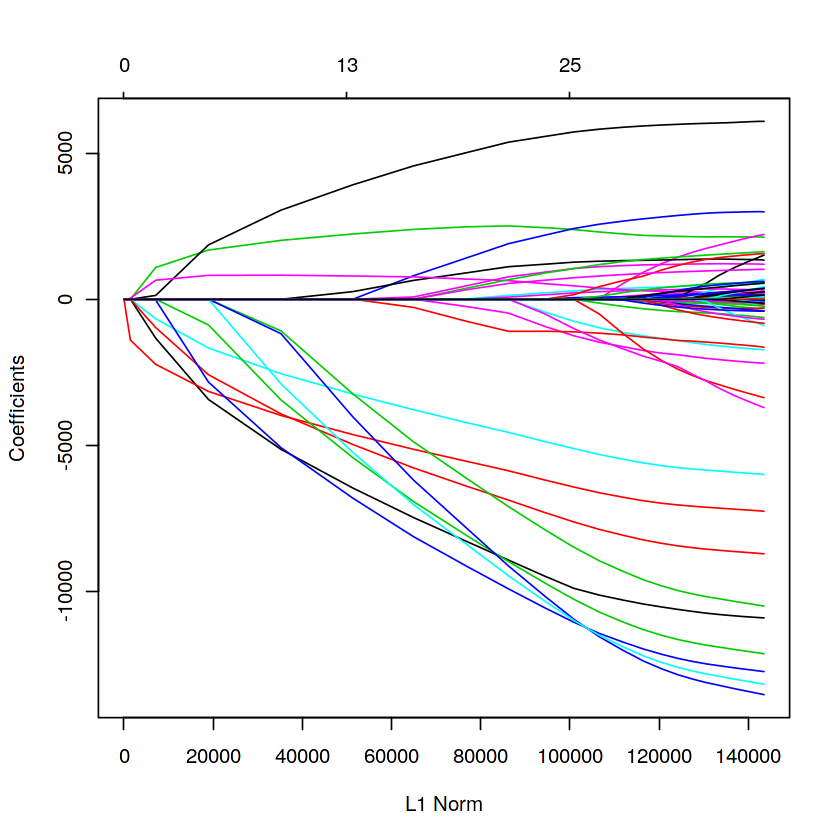

In [19]:
ld = 10^seq(10, -2, length=100)

y = training_set$Purchase
rig.fit = glmnet(X_train, y, alpha=1, lambda=ld)
plot(rig.fit)

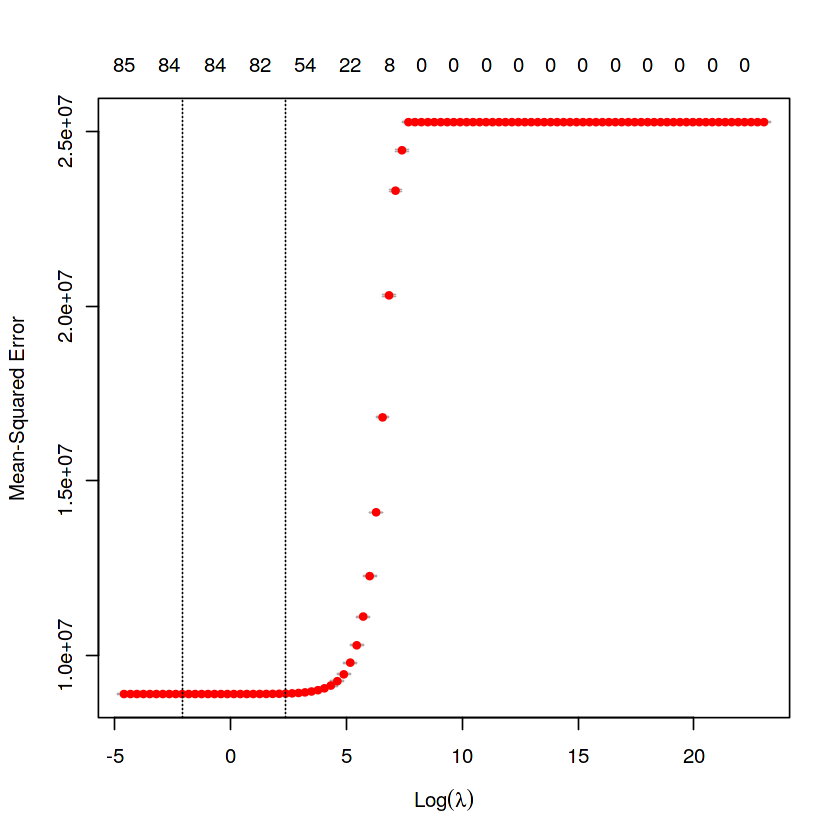

In [20]:
cvglm = cv.glmnet(X_train, y, alpha=1, lambda=ld, nfolds=5)
plot(cvglm)

In [21]:
best = cvglm$lambda.min
best

[1] 0.1232847

In [22]:
predict(rig.fit, s=best, type='coefficients')

86 x 1 sparse Matrix of class "dgCMatrix"
                                         1
(Intercept)                   13256.068470
GenderM                         -57.387382
Age18-25                       -182.873413
Age26-35                       -109.879434
Age36-45                          .       
Age46-50                         16.987562
Age51-55                        253.095455
Age55+                          123.467678
Occupation1                     -34.295846
Occupation2                      33.520293
Occupation3                     246.422142
Occupation4                     142.192682
Occupation5                      69.951928
Occupation6                     213.714614
Occupation7                     104.245059
Occupation8                    -314.829613
Occupation9                     106.536774
Occupation10                    -29.990258
Occupation11                    104.786651
Occupation12                    266.521915
Occupation13                     68.964605
Occupation14

In [23]:
pred_rl = predict(rig.fit, s=best, newx = X_val)
sqrt(mean((validation_set$Purchase - pred_rl)^2))

[1] 2970.446

# Predicting Test Set

In [24]:
test_set = model.matrix(Purchase ~ ., data = test_)[,-1]
pred_test = predict(rig.fit, s=best, newx = test_set)

submission = data.frame('Purchase'=pred_test,
                        'User_ID'=test$User_ID,
                        'Product_ID'=test$Product_ID)
names(submission)[1] = 'Purchase'

write.csv(submission, 'RL.csv', row.names = F)